In [27]:
import sympy as sp
import numpy as np
from sympy.functions import sec, tan

# q1:theta q2:positionx
# ───────────── 1. Variables ─────────────────────────
m, M, g = sp.symbols('m M g', positive=True)  
l = sp.symbols('l', positive=True)        # Pendulum length (0.37~0.7 m)
b = 1/l                                   # b = 1/l
a=g/l
k, P, k_v = sp.symbols('k P k_v', positive=True)
m22_0 = sp.symbols('m22_0', positive=True)
# M_I = sp.Matrix([[1,0], [0,1]])  # Inertia matrix
M_I = sp.eye(2)      # Identity


# ------- X PARAMETERS and RELATED -------
theta,x = sp.symbols('theta x')               # pendulum anlge
c = sp.cos(theta)
x_star,dx_star = sp.symbols('x_star dx_star')        # cart position, desired position
dtheta,dx = sp.symbols('dtheta dx')       # derivatives of q1 and q2

q = sp.Matrix([theta, x])  # State vector
# M_I = sp.Matrix([[1, b*sp.cos(q[0])], [b*sp.cos(q[0]), (M+m)/(m*l**2)]])  # Inertia matrix
V=(g/l)*sp.cos(q[0])

p  = sp.Matrix([dtheta, dx])
p_hat  = sp.Matrix([dtheta, dx-dx_star])  # Momentum vector (p = dq/dt)

# ───────────── 2. inertial matrix  M_d(θ) ────────────────
Md = sp.Matrix([[ k*b**2/3 * c**3,   -k*b/2 * c**2 ],
                [ -k*b/2 * c**2,      k*c + m22_0   ]])
Md_inv = Md.inv()
# Md's derivative related to θ 
Md_p = Md.diff(theta)

# ───────────── 3. F(θ)and its derivative with α(θ) ─────────────────
F = 3*l*sp.log( sp.sec(theta) + sp.tan(theta)) + 6*l*m22_0/k * sp.tan(theta)
F_p = sp.diff(F, theta)  # F'(θ)

alpha_coeff = -k**2 * c**3 * sp.sin(theta)/(12*l**2)
alpha1 = alpha_coeff * sp.Matrix([ [ c/l ], [-1] ])   # (2×1)




# ───────────── 4. A1 ~ A4  (equation 12a–12d) ─────────────────
#A1(θ)
m11, m12, m22 = Md[0,0], Md[0,1], Md[1,1]
A1 = -( m12*F_p + m22 )                               # (12a)


# bracket = sp.Matrix([[sp.diff(m11,theta)-alpha1[0], sp.diff(m12,theta) ],[sp.diff(m12,theta)-alpha1[1],sp.diff(m22,theta)]])  # (12b)

bracket = sp.Matrix([
    [sp.diff(m11, theta) - alpha1[0], sp.diff(m12, theta)],
    [sp.diff(m12, theta)            , sp.diff(m22, theta) - alpha1[1]]  # Symmetrized
])
A2 = -0.5 * m12 * Md_inv * bracket *  Md_inv
A3 = -m12 * (6*a*sp.sin(theta)) / (k*b**2*c**3) + P*F*A1
A4 = sp.Matrix([[-c/l, 1]]) * Md_inv                 # (12d)

# ───────────── 5.desired potential energy V_d(q)  ──────────── 
V_d = 3*g*l / (k* c**2) + P/2*(x-x_star+F)**2      #    

# ───────────── 6. Control output u ─────────────────────
#∂V_d/∂q
q_vec = sp.Matrix([theta, x])
dVd_dq = sp.Matrix([sp.diff(V_d, theta), sp.diff(V_d, x)])

FactorA1 = A1*P*(x-x_star)
FactorA2 = (p_hat.T*A2*p_hat)[0,0]
FactorA3 = A3
FactorA4 = -k_v * (A4 * p_hat)[0,0]

# Control output u (eq 13)
u = FactorA2 + FactorA3 + FactorA4
ddq = a * sp.sin(q[0])*sp.Matrix([1, 0]) + sp.Matrix([-b*c, 1]) * u

Minv = M_I.inv()
H = sp.Rational(1,2) * (p.T * Minv * p)[0] + V   # [0] to extract scalar
Hd = 0.5*(p.T*Md_inv*p)[0] + V_d


params = {
    l:1, k:0.01, P:1, m22_0:0.01, k_v:0.01, x_star:20, dx_star:2,
    m:11, M:3.0, g:1       
}

# Lambdas (after your params dict)
u_num      = sp.lambdify((theta, x, dtheta, dx), u.subs(params), 'numpy')
ddq_num    = sp.lambdify((theta, x, dtheta, dx), ddq.subs(params), 'numpy')

# numeric mass matrix
M_I_num = sp.lambdify((theta, x, m, M, g, l), M_I, 'numpy')

# identical inertia matrix
# def nu_func(theta_val, x_val, dtheta_val, dx_val):
#     ddq = ddq_num(theta_val, x_val, dtheta_val, dx_val)
#     return ddq

def nu_func(theta_val, x_val, dtheta_val, dx_val):
    u = u_num(theta_val, x_val, dtheta_val, dx_val)
    return u



### Observer design
This block is used to design the observer design of the entire system using Luenberger Observer to track the linearized model

In [28]:
A_obsv = np.array([
    [0, 1, 0, 0, 0],
    [(params[m]+params[M])*params[g]/(params[M]*params[l]), 0, 0, 0, -(params[m]+params[M])*params[g]/(params[M]*params[l])],
    [0, 0, 0, 1, 0],
    [-params[m]*params[g]/params[M], 0, 0, 0, params[m]*params[g]/params[M]],
    [0, 0, 0, 0, 0]])
B_obsv = np.array([[0],[-1/(params[M]*params[l])],[0],[1/params[M]],[0]])
c_obsv = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])

# Construct the observability matrix
O = np.vstack([
    c_obsv,
    c_obsv @ A_obsv,
    c_obsv @ np.linalg.matrix_power(A_obsv, 2),
    c_obsv @ np.linalg.matrix_power(A_obsv, 3),
    c_obsv @ np.linalg.matrix_power(A_obsv, 4)
])

# Calculate the rank of the observability matrix
observability_rank = np.linalg.matrix_rank(O)
observability_rank

5

The Observability rank is 5, full rank. which means the system is fully observable.
With the measurement option selected as real theta and x, the observation system can be represneted as
$$
\dot{\hat{\xi}} = \hat{A}\hat{\xi} + \hat{B}u + L(y_m - \hat{C}\hat{\xi})
$$

In [29]:
from scipy.signal import place_poles
from scipy.signal import place_poles


def setup_observer_matrices(params_num):
    """Calculates the constant matrices A_hat, B_hat, C_hat, and L."""
    A_lin = sp.Matrix([
        [0, 1, 0, 0],
        [(M + m) * g / (M * l), 0, 0, 0],
        [0, 0, 0, 1],
        [-m * g / M, 0, 0, 0]
    ])
    E_d = sp.Matrix([0, -(M + m) * g / (M * l), 0, m * g / M])
    
    A_hat = sp.zeros(5, 5)
    A_hat[:4, :4] = A_lin
    A_hat[:4, 4] = E_d

    B_hat = sp.Matrix([0, -1 / (M * l), 0, 1 / M, 0])
    C_hat = sp.Matrix([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    
    # Substitute numerical values
    A_hat_num = np.array(A_hat.subs(params_num)).astype(np.float64)
    B_hat_num = np.array(B_hat.subs(params_num)).astype(np.float64)
    C_hat_num = np.array(C_hat.subs(params_num)).astype(np.float64)

    # Calculate L using pole placement
    desired_poles = np.array([-5, -5.1, -6, -6.1, -7])
    result = place_poles(A_hat_num.T, C_hat_num.T, desired_poles)
    L_num = result.gain_matrix.T
    
    return A_hat_num, B_hat_num, C_hat_num, L_num


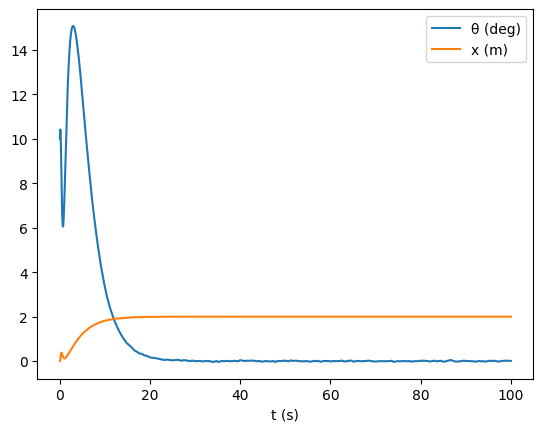

In [ ]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp


# M_I(q): inverse mass matrix function -> numpy 2x2
M_I_num = sp.lambdify((theta, x, m, M, g, l), M_I, 'numpy')


# A global counter to control how often we print debug info
debug_counter = 0

# A global counter to control how often we print debug info
debug_counter = 0

th_filtered_prev = 0.0
dth_filtered_prev = 0.0
is_first_run = True # A flag to initialize the filter correctly


params_num = params
A_hat, B_hat, C_hat, L = setup_observer_matrices(params_num)
last_u_for_observer = 0.0 # Global to store control input for observer


def dynamics_ph(t, z):
    global debug_counter, th_filtered_prev, dth_filtered_prev, is_first_run
    
    # 1. Unpack the TRUE state vector
    th, x, dth, dx = z[0:4]
    z_hat = z[4:9]
    th_hat, x_hat, dth_hat, dx_hat = z_hat[0], z_hat[2], z_hat[1], z_hat[3]
    
    # 2. Simulate Sensor Noise  
    angle_noise_std_dev = 0.005
    th_measured = th + np.random.normal(0, angle_noise_std_dev)
    x_measured = x + np.random.normal(0, 0.01)  # Simulate noise in position
    y_measured = np.array([th_measured, x_measured])  # Measurement vector

    # 4. Controller uses the CLEAN, FILTERED values
    v = nu_func(th_hat, x_hat, dth_hat, dx_hat)

    # 5. Translate 'v' into the real physical force 'u' (using TRUE state)
    u = params[m] * params[l] * (
            (params[g] / params[l]) * np.cos(th) * np.sin(th) -
            np.sin(th) * dth**2 +
            ((np.sin(th)**2 + params[M] / params[m]) * v / params[l])
    )

    # 6. Solve for real accelerations (using TRUE state)
    a1 = params[M] + params[m]
    b1 = params[m] * params[l] * np.cos(th)
    c1 = u + params[m] * params[l] * np.sin(th) * (dth**2)
    
    d1 = params[m] * params[l] * np.cos(th)
    e1 = params[m] * params[l]**2
    f1 = params[m] * params[g] * params[l] * np.sin(th)

    A = np.array([[a1, b1], [d1, e1]])
    B = np.array([c1, f1])
    
    solution = np.linalg.solve(A, B)
    ddx, ddth = solution[0], solution[1]
    dz_true_dt = np.array([dth, dx, ddth, ddx])

    y_hat = C_hat @ z_hat
    error = y_measured - y_hat
    dz_hat_dt = (A_hat @ z_hat) + (B_hat.flatten() * u) + (L @ error)


    
    # 6. Return the derivative of the TRUE state vector
    return np.concatenate((dz_true_dt, dz_hat_dt))


# simulate
T = 100
z0_actural = np.array([np.deg2rad(10.0), -0.1, 0.1, 0, ], dtype=float)  # [θ, x, pθ, px]
z0_observer = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float)  # Initial observer state set to zero
z0 = np.concatenate((z0_actural, z0_observer))  # Combine the true
sol = solve_ivp(dynamics_ph, (0, T), z0, t_eval=np.linspace(0, T, 2000),
                rtol=1e-3, atol=1e-5) 


t = sol.t
theta_traj = sol.y[0]   
x_traj = sol.y[3]

plt.plot(t, np.rad2deg(theta_traj), label='θ (deg)')
plt.plot(t, x_traj, label='x (m)')
plt.xlabel('t (s)')
plt.legend()
plt.show()

